In [21]:
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from statsmodels.api import Logit
import glob
import numpy as np
from sklearn import metrics
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

In [9]:
paraTrain = glob.glob("data/training_set/Parasitized/*")
noParaTrain = glob.glob("data/training_set/Uninfected/*")
paraTest = glob.glob("data/testing_set/Parasitized/*")
noParaTest = glob.glob("data/testing_set/Uninfected/*")

trainSize = 400
paraTrainIndexes = np.random.randint(len(paraTrain), size=trainSize)
paraTrain = [mpimg.imread(paraTrain[i]) for i in paraTrainIndexes]
noParaTrainIndexes = np.random.randint(len(noParaTrain), size=trainSize)
noParaTrain = [mpimg.imread(noParaTrain[i]) for i in noParaTrainIndexes]
trainData = paraTrain + noParaTrain
trainLabels = [True]*trainSize + [False]*trainSize

testSize = 80
paraTestIndexes = np.random.randint(len(paraTest), size=testSize)
paraTest = [mpimg.imread(paraTest[i]) for i in paraTestIndexes]
noParaTestIndexes = np.random.randint(len(noParaTest), size=testSize)
noParaTest = [mpimg.imread(noParaTest[i]) for i in noParaTestIndexes]
testData = paraTest + noParaTest
testLabels = [True]*testSize + [False]*testSize

trainHist = []
for i in trainData:
    flatImage = i.flatten()
    flatImage = flatImage[flatImage != 0]
    trainHist.append(np.histogram(flatImage, bins=20)
                         [0]/float(len(flatImage)))

testHist = []
for i in testData:
    flatImage = i.flatten()
    flatImage = flatImage[flatImage != 0]
    testHist.append(np.histogram(flatImage, bins=20)
                        [0]/float(len(flatImage)))

ns_probs = [0 for _ in range(len(testLabels))]
ns_auc = roc_auc_score(testLabels, ns_probs)

In [10]:
logitModel = Logit(trainLabels, trainHist)
logit_res = logitModel.fit()
pscore_logit = logit_res.predict(testHist)

Optimization terminated successfully.
         Current function value: 0.173265
         Iterations 10


In [12]:
randomForestClas = RandomForestClassifier(n_estimators=100)
randomForestClas.fit(trainHist, trainLabels)
pscore_forest = randomForestClas.predict_proba(testHist)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.962
Decision Tree: ROC AUC=0.056
Random Forest: ROC AUC=0.984


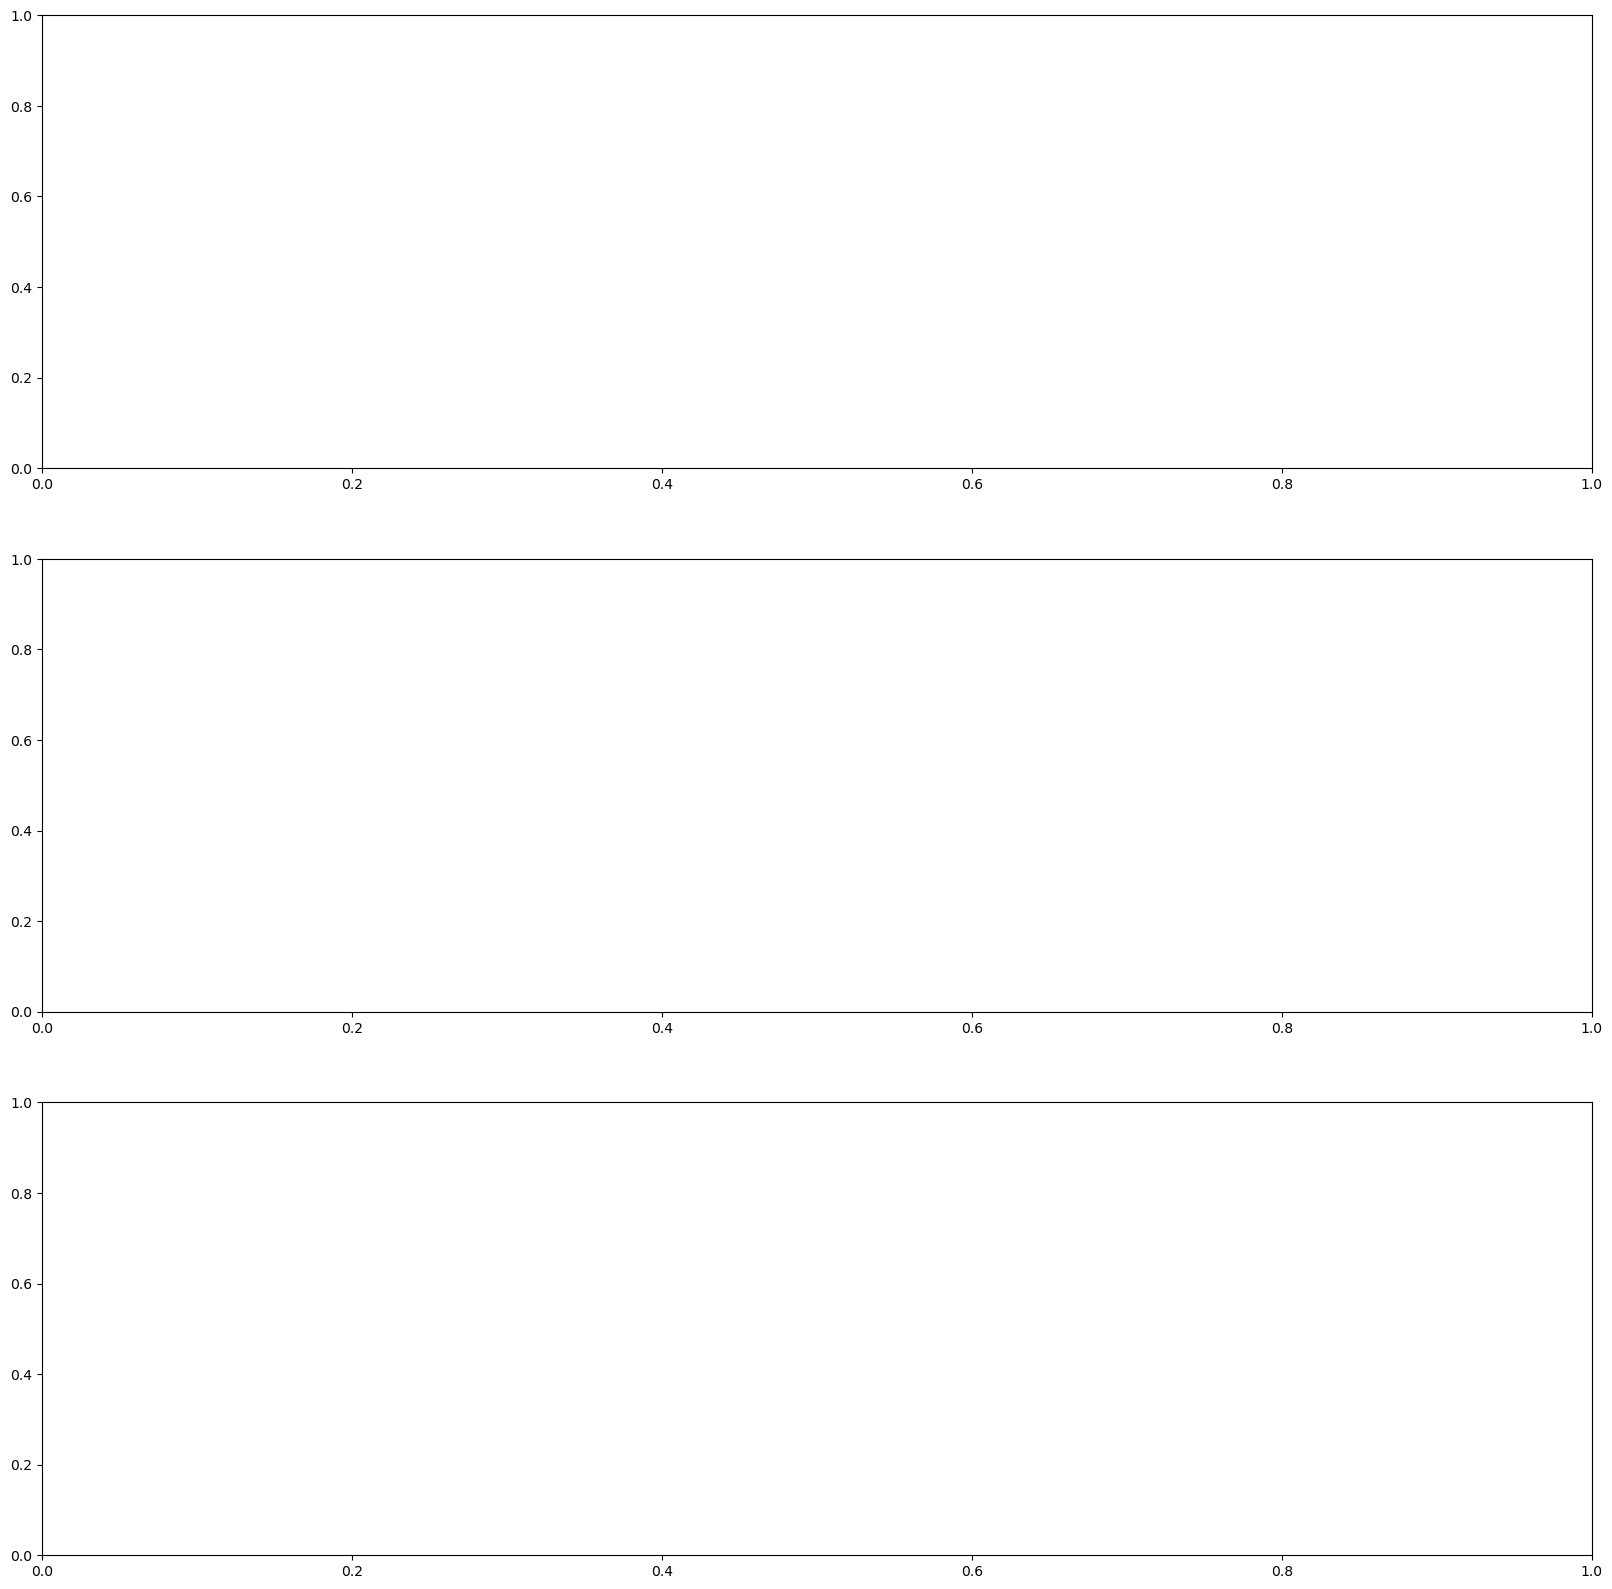

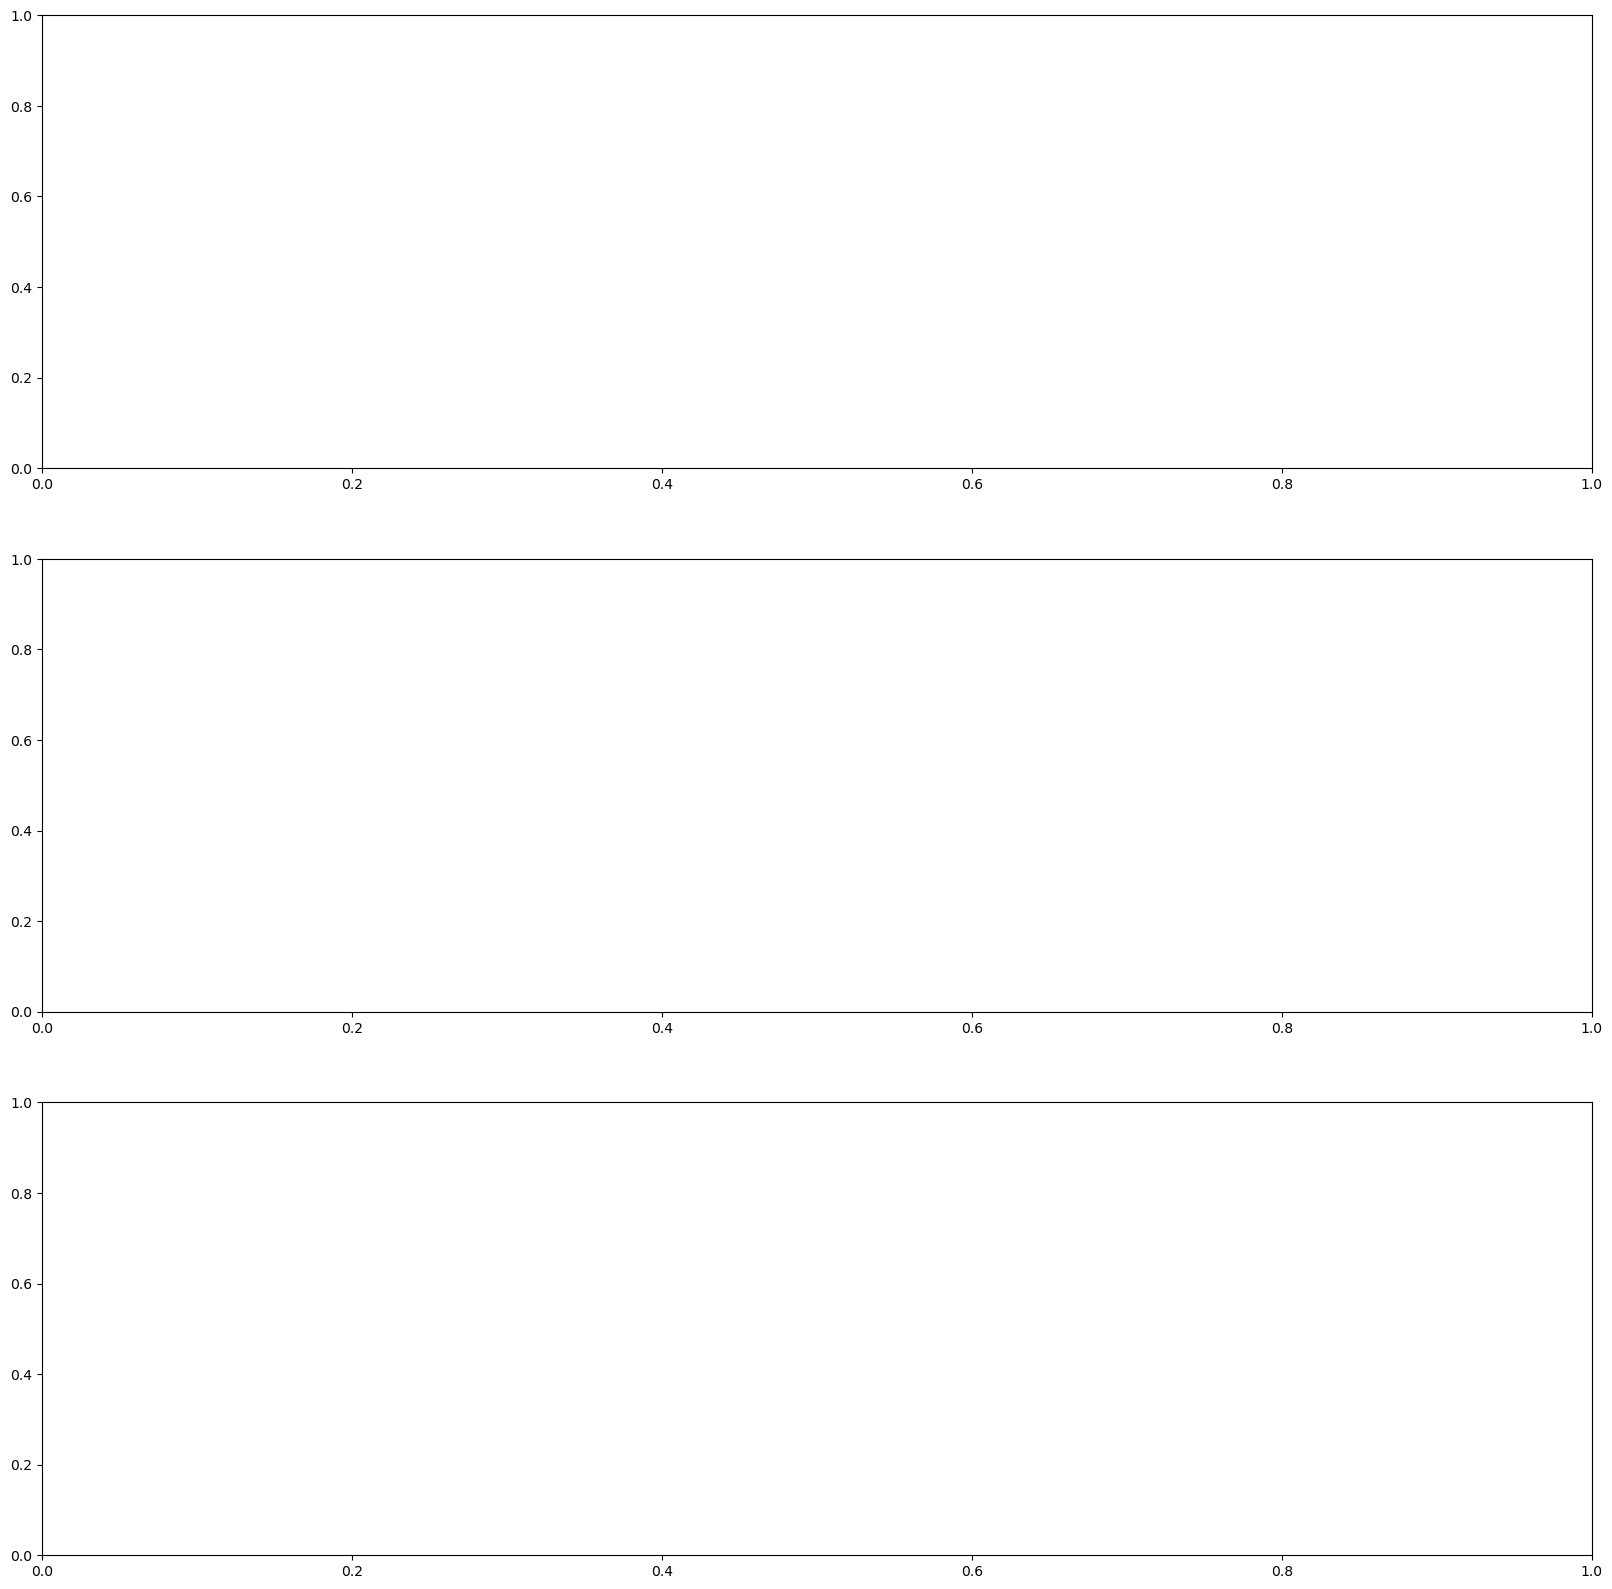

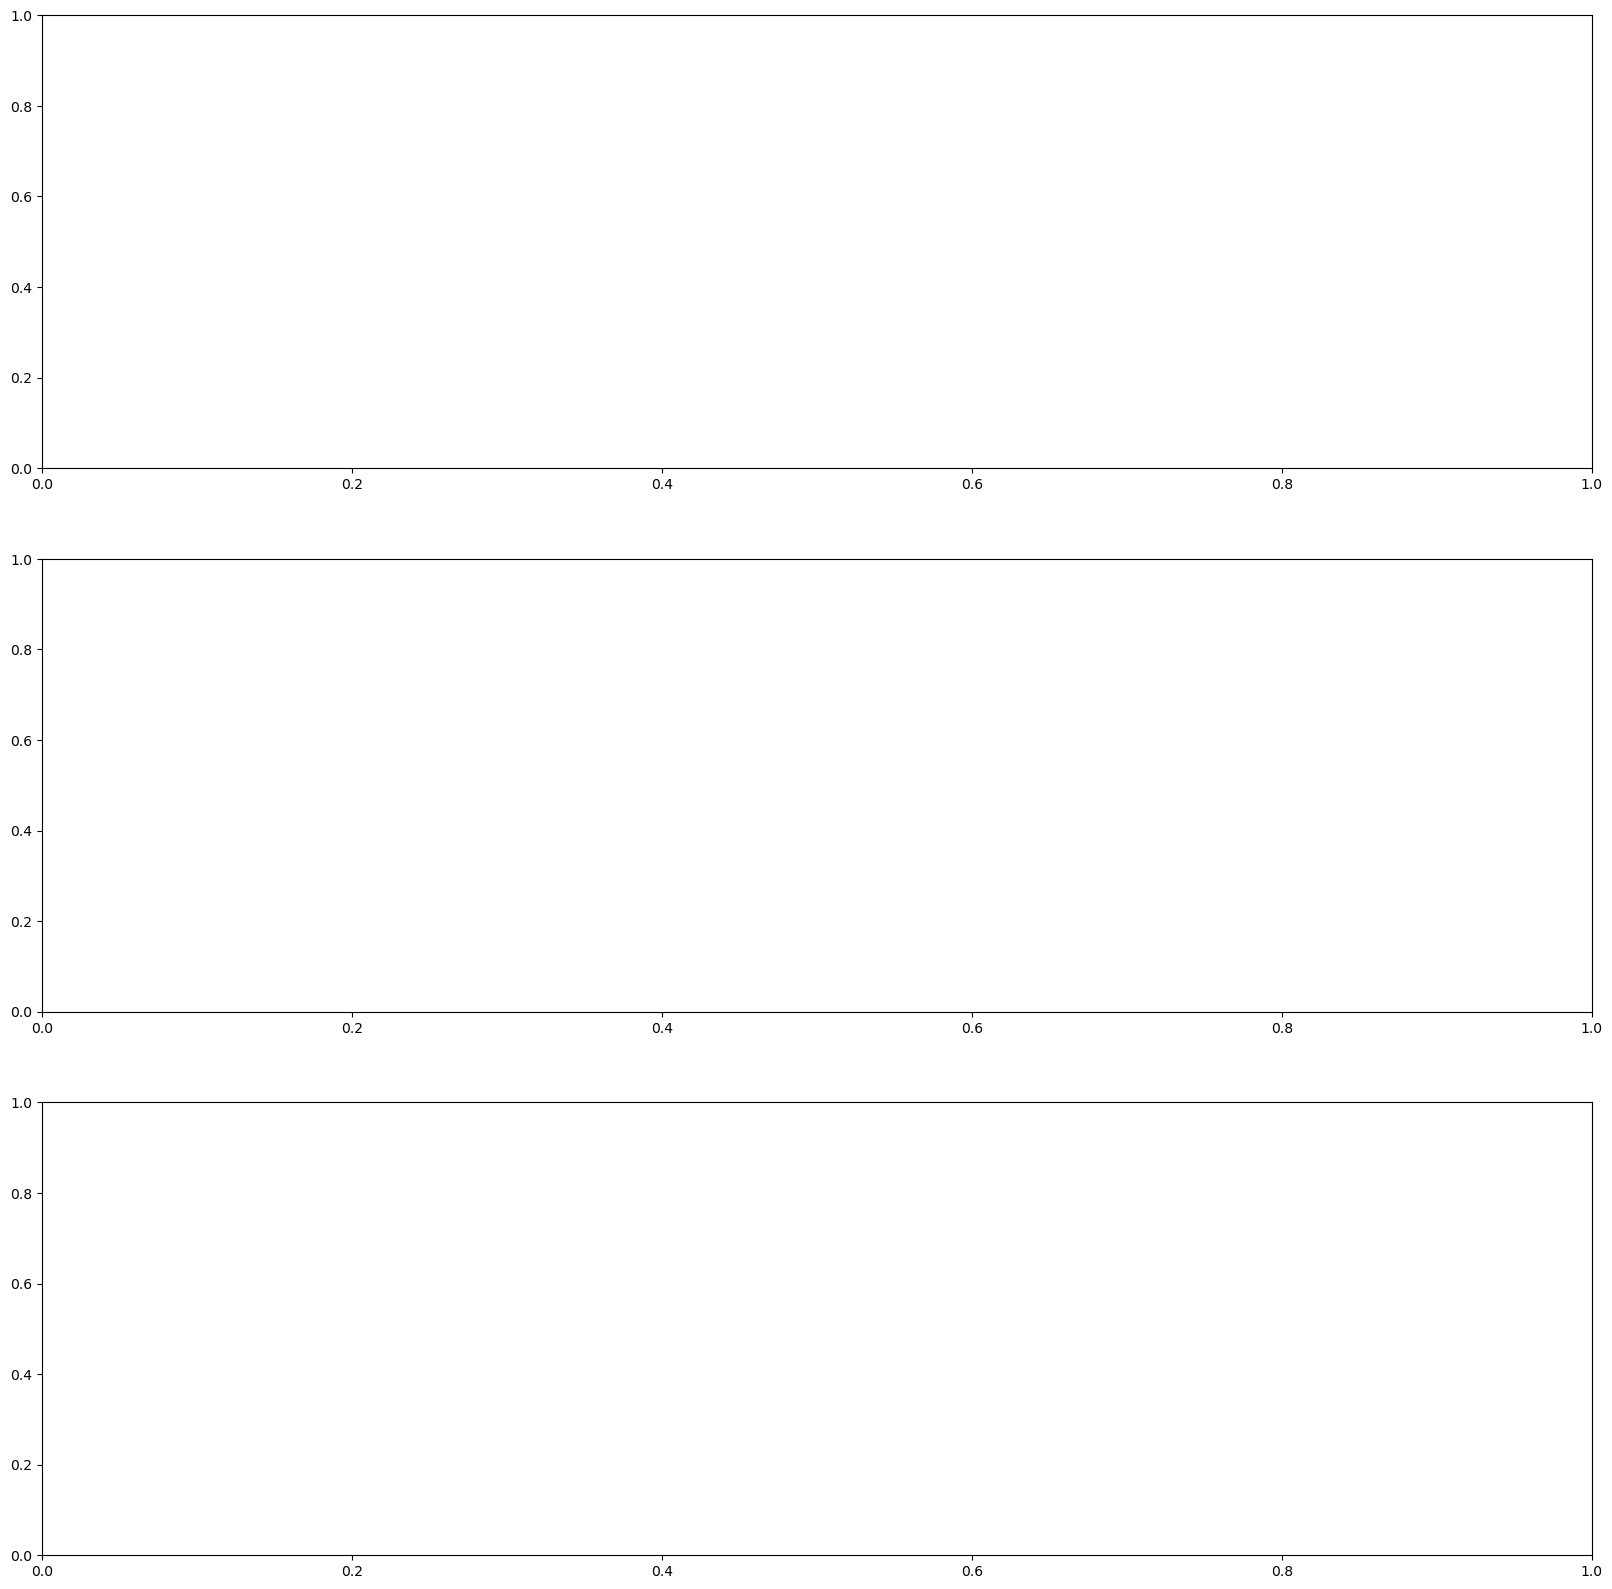

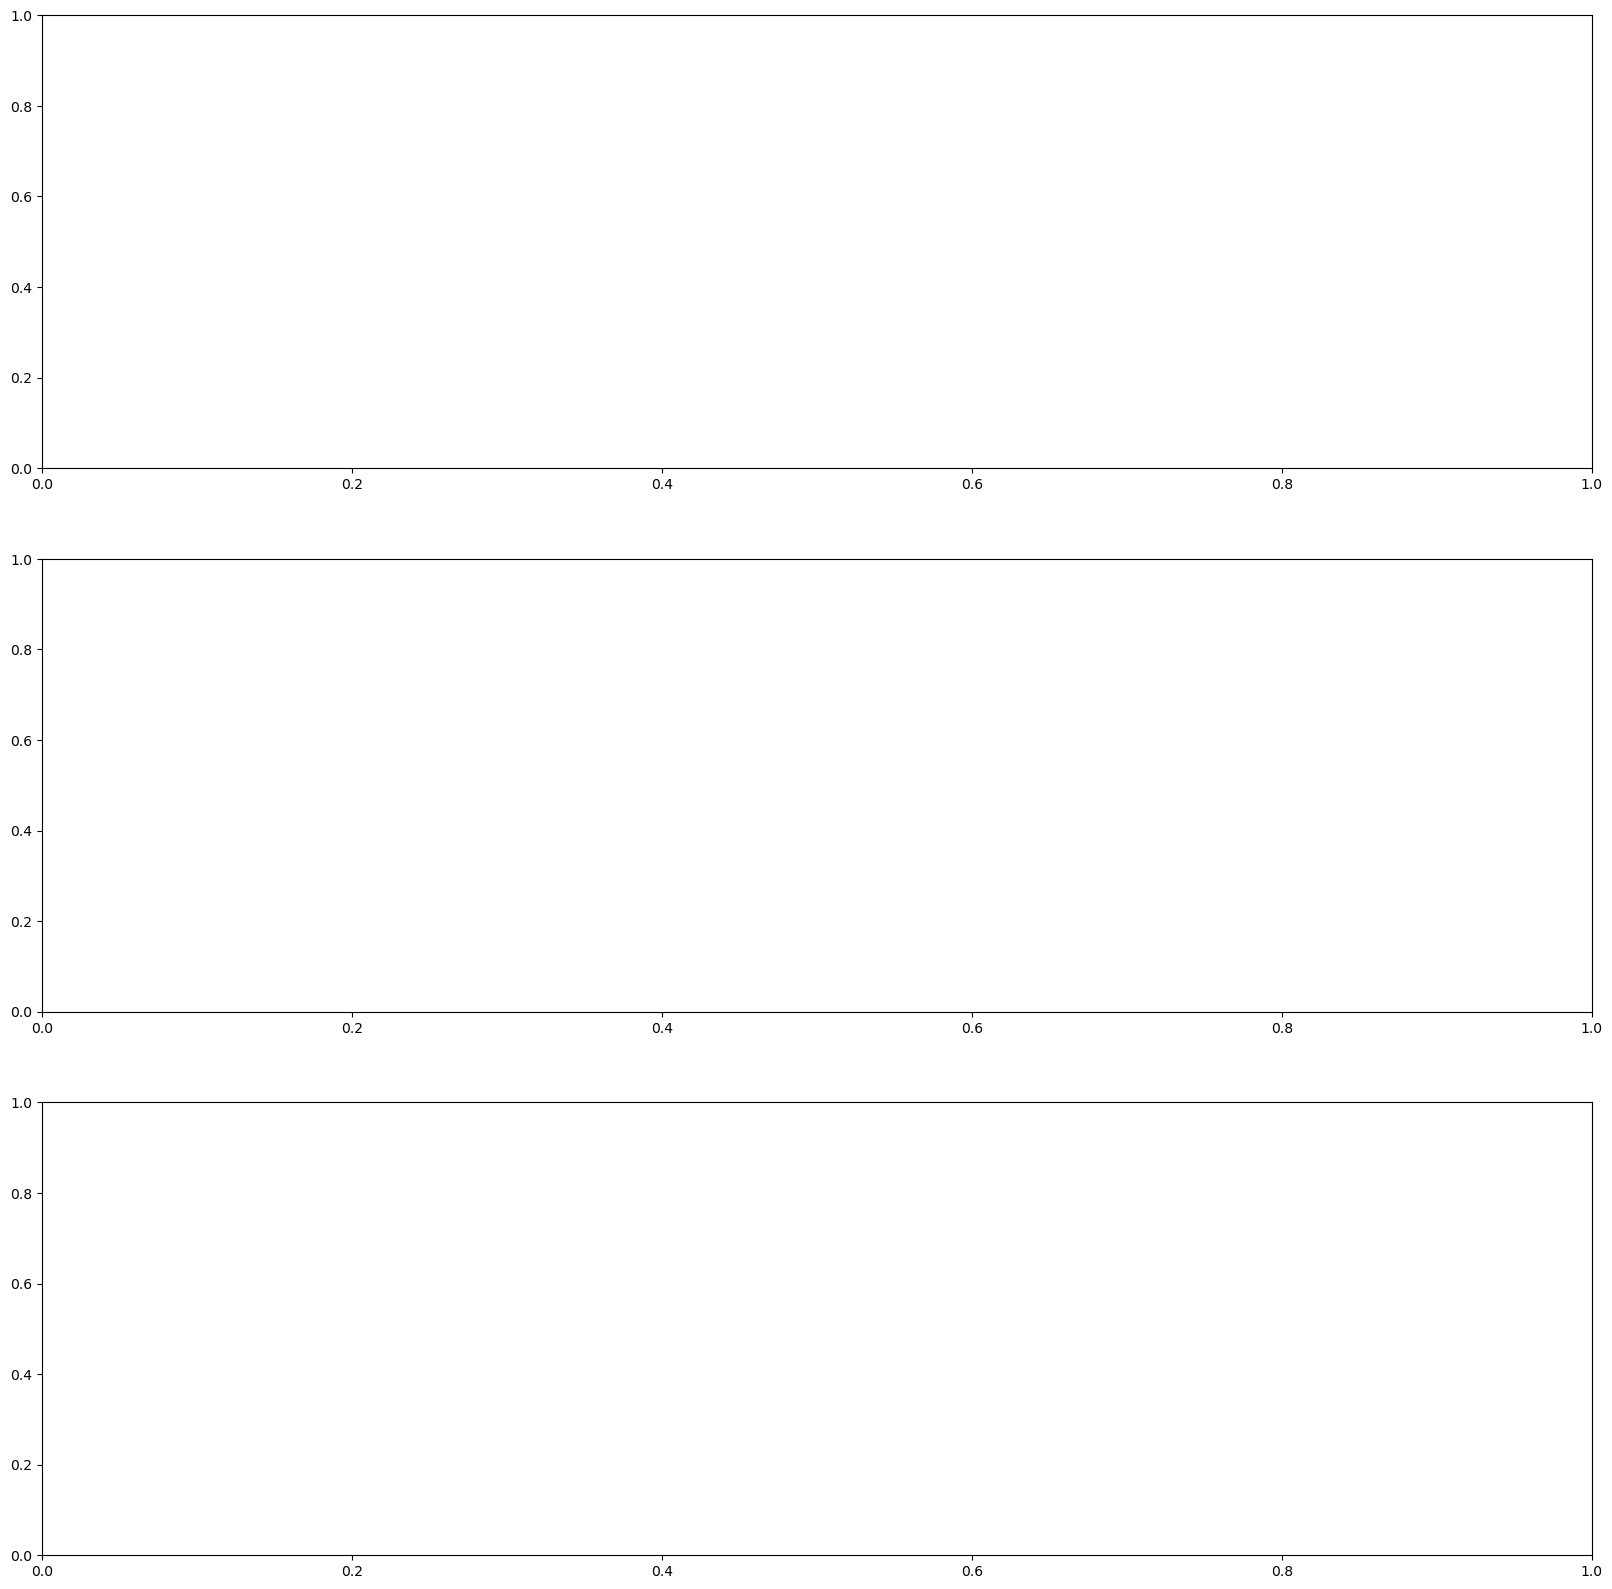

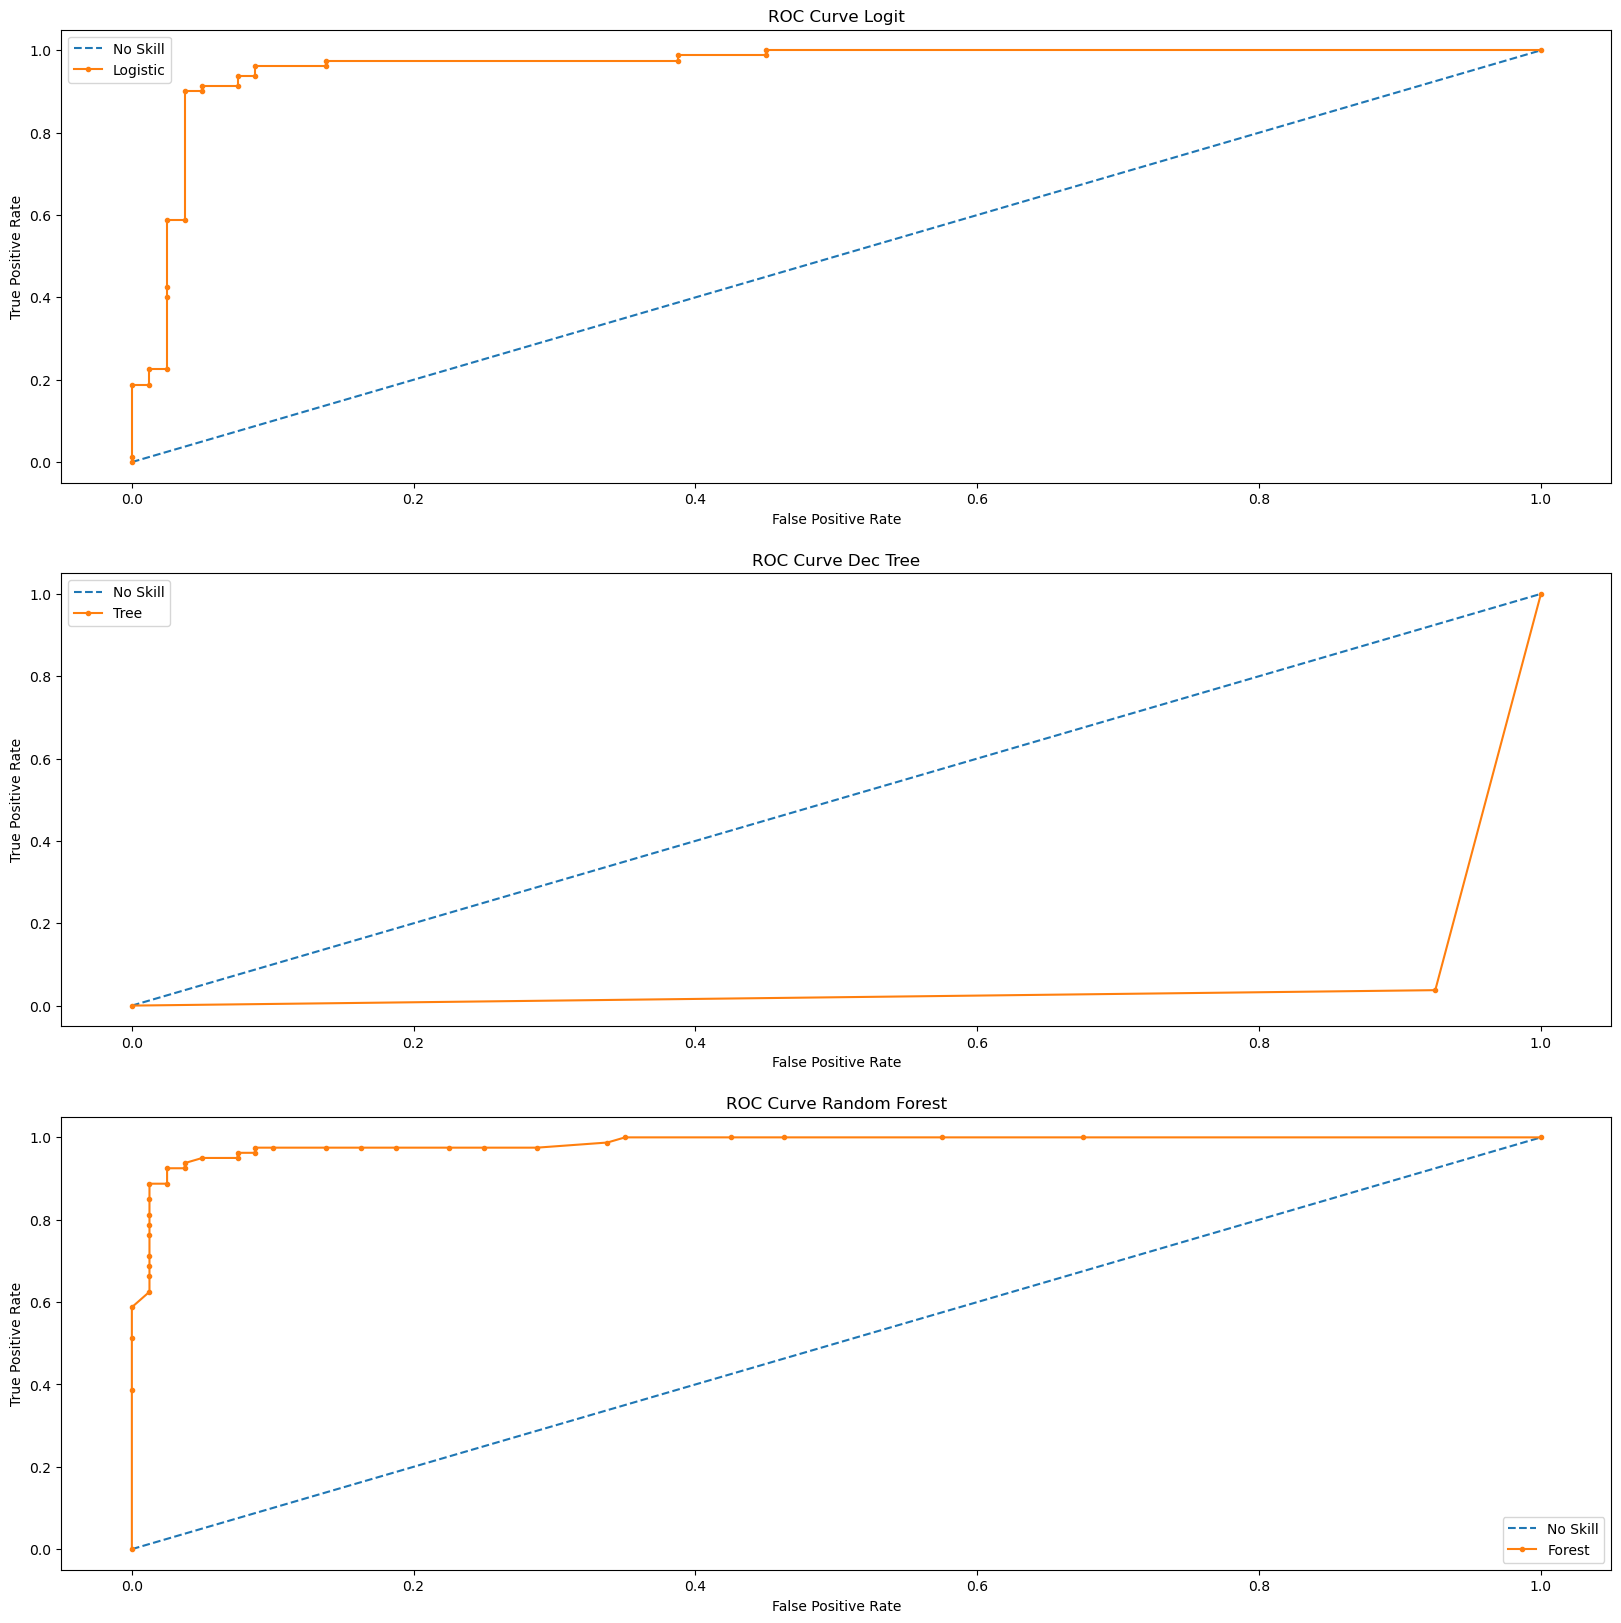

In [29]:
fig, axs = plt.subplots(2,1)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testLabels))]

# calculate scores
ns_auc = roc_auc_score(testLabels, ns_probs)
lr_auc_logit = roc_auc_score(testLabels, pscore_logit)
lr_auc_forest = roc_auc_score(testLabels, pscore_forest[:, 1])

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc_logit))
print('Random Forest: ROC AUC=%.3f' % (lr_auc_forest))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testLabels, ns_probs)
logit_fpr, logit_tpr, _ = roc_curve(testLabels, pscore_logit)
forest_fpr, forest_tpr, _ = roc_curve(testLabels, pscore_forest[:, 1])


# plot the roc curve for the model
axs[0].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
axs[0].plot(logit_fpr, logit_tpr, marker='.', label='Logistic')
axs[1].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
axs[1].plot(forest_fpr, forest_tpr, marker='.', label='Forest')

# axis labels
plt.setp(axs[0], xlabel='False Positive Rate', ylabel='True Positive Rate', title = "ROC Curve Logit")
plt.setp(axs[1], xlabel='False Positive Rate', ylabel='True Positive Rate', title = "ROC Curve Random Forest")

# show the legend
axs[0].legend()
axs[1].legend()

# show the plot
plt.show()